# ML Classification task

In [2]:
import sys
import pandas as pd
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score


sys.path.append('../')
from src.utility import (
    train_timer,
    evaluate_model,
    print_metrics,
    plot_evaluation_graphs,
    train_set_evaluation,
    plot_accuracy
)

In [3]:
# warning messages are not displayed
import warnings
warnings.filterwarnings("ignore")
    

In [4]:
titanic_train = pd.read_csv('../data/processed/titanic_train.csv')
titanic_test = pd.read_csv('../data/processed/titanic_test.csv')
titanic_dev = pd.read_csv('../data/processed/titanic_dev.csv')

In [5]:
X_train = titanic_train.drop(columns=['Survived'])
Y_train = titanic_train['Survived']

X_test = titanic_test.drop(columns=['Survived'])
Y_test = titanic_test['Survived']

X_dev = titanic_dev.drop(columns=['Survived'])
Y_dev = titanic_dev['Survived']

## Train and evaluate the classification model

In [6]:
RandomForest = RandomForestClassifier(
    n_estimators=10, 
    max_depth=5,
    random_state=18
)

# Train the model
RandomForest.fit(X_train, Y_train)

# Evaluate the model on the training, development and test sets
Yhat_train = RandomForest.predict(X_train)
Yhat_dev = RandomForest.predict(X_dev)
Yhat_test = RandomForest.predict(X_test)
accuracy_train = accuracy_score(Y_train, Yhat_train)
accuracy_dev = accuracy_score(Y_dev, Yhat_dev)
accuracy_test = accuracy_score(Y_test, Yhat_test)
print(f'Accuracy (train): {accuracy_train:.3f}')
print(f'Accuracy (dev): {accuracy_dev:.3f}')
print(f'Accuracy (test): {accuracy_test:.3f}')

Accuracy (train): 0.870
Accuracy (dev): 0.853
Accuracy (test): 0.765


In [7]:
# Perform Grid Search
# Concatenate train and dev sets for cross-validation
X_train_cv = pd.concat([X_train, X_dev])
Y_train_cv = pd.concat([Y_train, Y_dev])

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [16, 32, 64],
    'max_depth': [2, 4, 8, 16],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Grid Search with cross validation
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=18),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train_cv, Y_train_cv)

# Print best parameters and score
print('Best parameters:')
pprint(grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.3f}")

# Evaluate best model on test
best_model = grid_search.best_estimator_
test_accuracy = accuracy_score(Y_test, best_model.predict(X_test))
print(f"Test set accuracy with best model: {test_accuracy:.3f}")


Best parameters:
{'max_depth': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 32}
Best cross-validation accuracy: 0.843
Test set accuracy with best model: 0.788


## Random Forest Classifier

Model training time: 39.00 ms
------------- MODEL METRICS --------------
Accuracy: 0.87
Precision: 0.87
Recall: 0.81
Specificity: 0.92


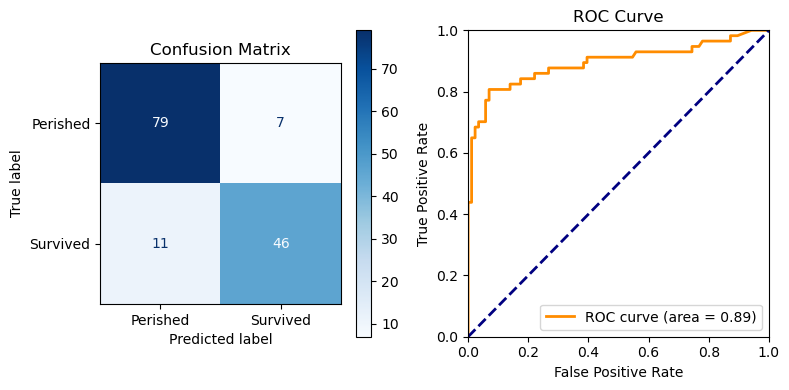

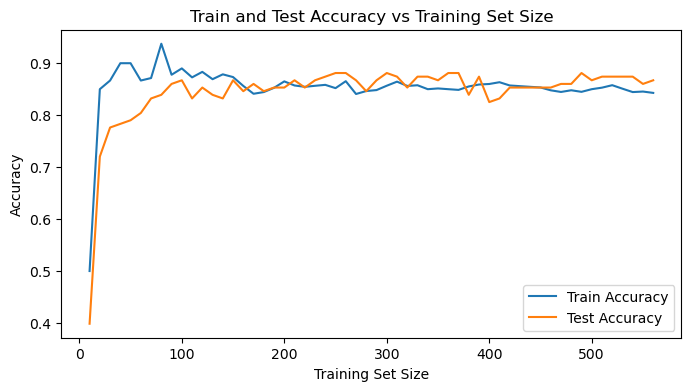

In [8]:
RandomForest = RandomForestClassifier(
    random_state=18,
    **grid_search.best_params_
)

train_timer(RandomForest, X_train, Y_train)
Yhat, Yhat_prob, metrics = evaluate_model(
    RandomForest,
    X_dev,
    Y_dev
)
print_metrics(metrics)
plot_evaluation_graphs(Y_dev, Yhat, Yhat_prob)
train_eval = train_set_evaluation(
    RandomForest,
    X_train,
    Y_train,
    X_dev,
    Y_dev
)
plot_accuracy(train_eval)

## Logistic Regression

Model training time: 44.53 ms
------------- MODEL METRICS --------------
Accuracy: 0.85
Precision: 0.82
Recall: 0.79
Specificity: 0.88


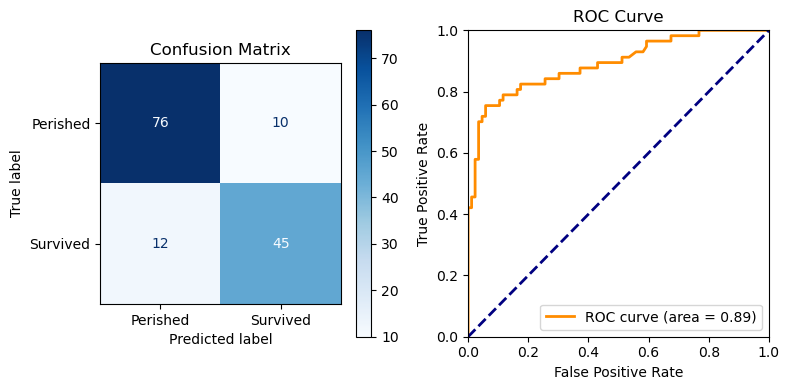

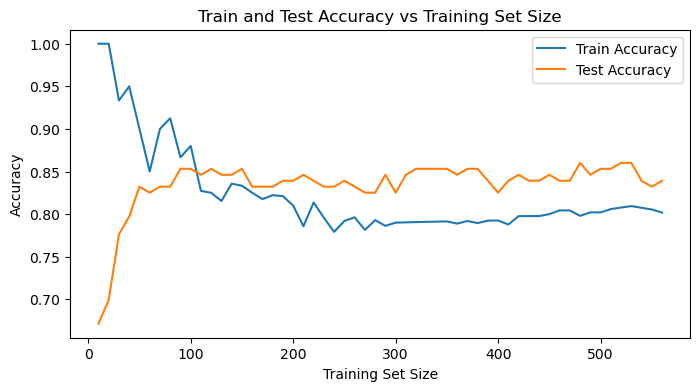

In [9]:
LogReg = LogisticRegression(max_iter=500)

train_timer(LogReg, X_train, Y_train)
Yhat, Yhat_prob, metrics = evaluate_model(
    LogReg,
    X_dev,
    Y_dev
)
print_metrics(metrics)
plot_evaluation_graphs(
    Y_dev,
    Yhat,
    Yhat_prob
)
train_eval = train_set_evaluation(
    LogReg,
    X_train,
    Y_train,
    X_dev,
    Y_dev
)
plot_accuracy(train_eval)

## Decision Tree

Model training time: 4.00 ms
------------- MODEL METRICS --------------
Accuracy: 0.78
Precision: 0.75
Recall: 0.68
Specificity: 0.85


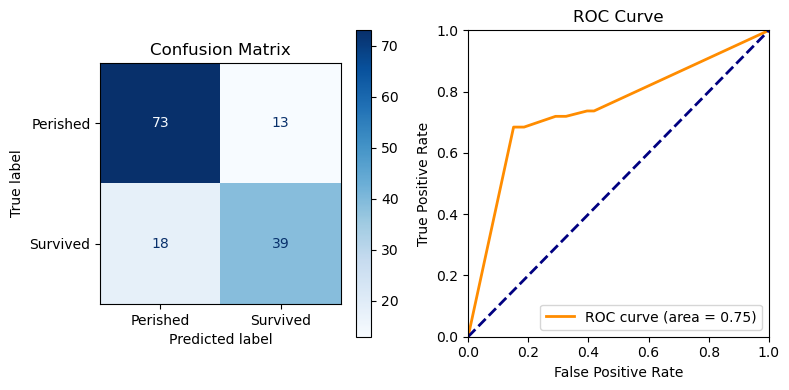

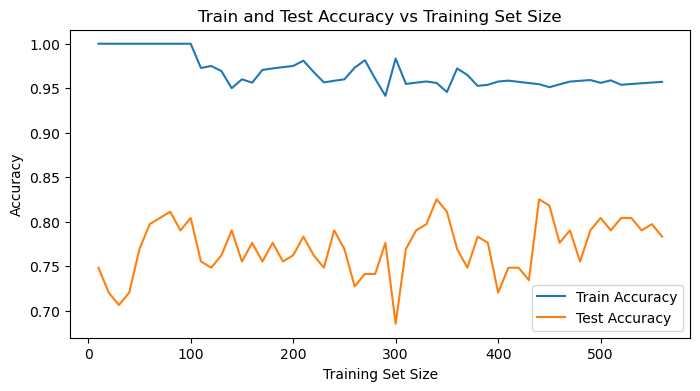

In [10]:
DecisionTree = DecisionTreeClassifier(
    max_depth=10,
    random_state=18
)

train_timer(DecisionTree, X_train, Y_train)
Yhat, Yhat_prob, metrics = evaluate_model(
    DecisionTree,
    X_dev,
    Y_dev
)
print_metrics(metrics)
plot_evaluation_graphs(Y_dev, Yhat, Yhat_prob)
train_eval = train_set_evaluation(
    DecisionTree,
    X_train,
    Y_train,
    X_dev,
    Y_dev
)
plot_accuracy(train_eval)


In [11]:
# Use the best model to predict the test set and evaluate the performance of the model 
Yhat, Yhat_prob, metrics = evaluate_model(
    RandomForest,
    X_test,
    Y_test
)
print_metrics(metrics)

------------- MODEL METRICS --------------
Accuracy: 0.79
Precision: 0.69
Recall: 0.69
Specificity: 0.84


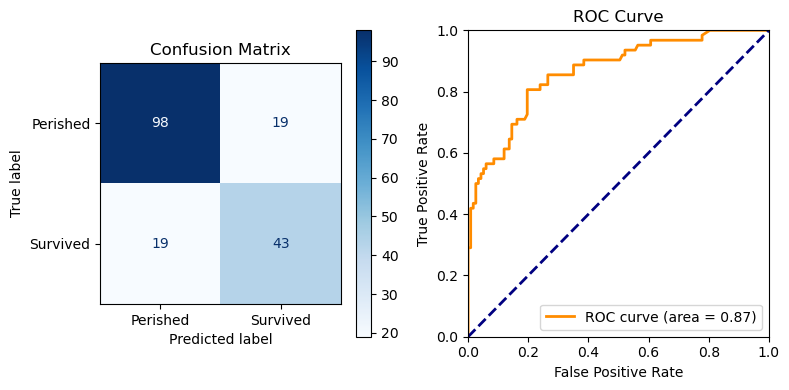

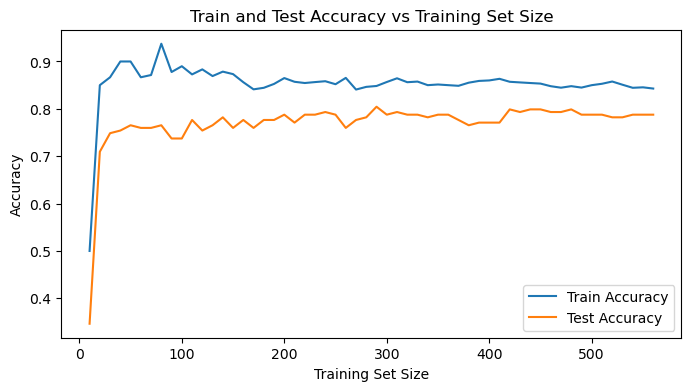

In [12]:
# Plot the evaluation graphs for the test set
plot_evaluation_graphs(Y_test, Yhat, Yhat_prob) # Plot evaluation graphs for the test set   
train_eval = train_set_evaluation(
    RandomForest,
    X_train,
    Y_train,
    X_test,
    Y_test
)
plot_accuracy(train_eval) # Plot accuracy graph for the test set\

Model training time: 72.56 ms
------------- MODEL METRICS --------------
Accuracy: 0.83
Precision: 0.82
Recall: 0.74
Specificity: 0.90


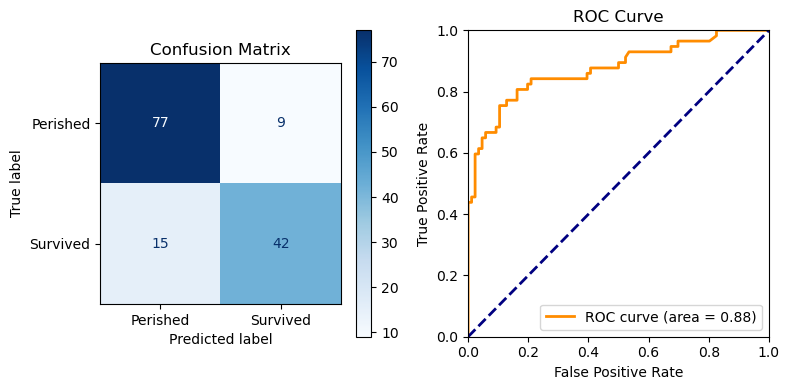

------------- MODEL METRICS --------------
Accuracy: 0.81
Precision: 0.71
Recall: 0.76
Specificity: 0.84


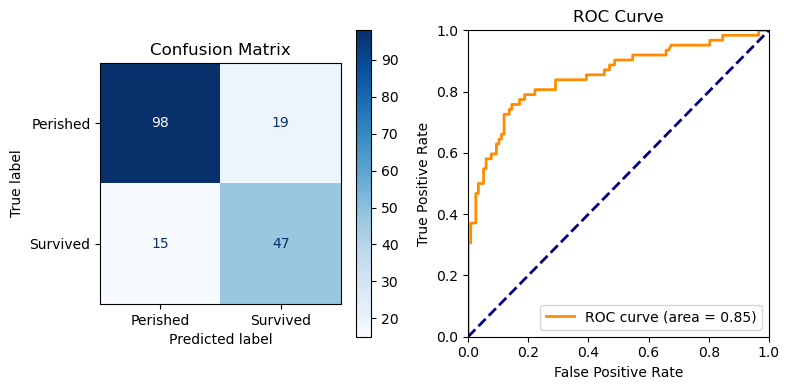

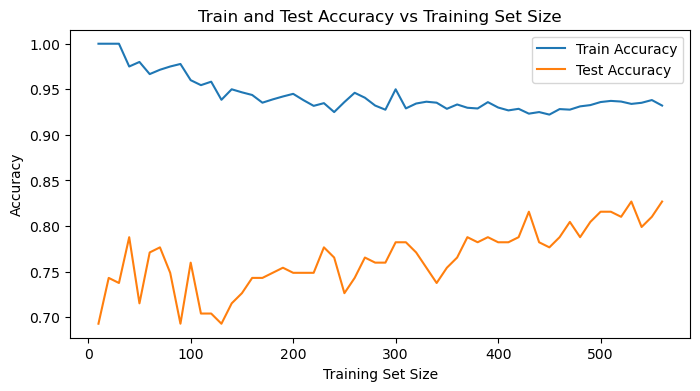

In [18]:
from sklearn.ensemble import VotingClassifier

# Create a VotingClassifier with the existing models
ensemble = VotingClassifier(
    estimators=[
        ('RandomForest', RandomForest),
        ('LogReg', LogReg),
        ('DecisionTree', DecisionTree)
    ],
    voting='soft'
)

# Train the ensemble model
train_timer(ensemble, X_train, Y_train)

# Evaluate the ensemble model on the development set
Yhat, Yhat_prob, metrics = evaluate_model(
    ensemble,
    X_dev,
    Y_dev
)
print_metrics(metrics)
plot_evaluation_graphs(Y_dev, Yhat, Yhat_prob)

# Evaluate the ensemble model on the test set
Yhat, Yhat_prob, metrics = evaluate_model(
    ensemble,
    X_test,
    Y_test
)
print_metrics(metrics)
plot_evaluation_graphs(Y_test, Yhat, Yhat_prob)

# Plot accuracy graph for the test set
train_eval = train_set_evaluation(
    ensemble,
    X_train,
    Y_train,
    X_test,
    Y_test
)
plot_accuracy(train_eval)

In [19]:
# Feature Engineering
def feature_engineering(df):
    # Create new features
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']
    
    # Binning Age
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=[0, 1, 2, 3, 4])
    
    # Binning Fare
    df['FareGroup'] = pd.qcut(df['Fare'], 4, labels=[0, 1, 2, 3])
    
    return df

# Apply feature engineering to the datasets
titanic_train = feature_engineering(titanic_train)
titanic_test = feature_engineering(titanic_test)
titanic_dev = feature_engineering(titanic_dev)

# Update the feature sets
X_train = titanic_train.drop(columns=['Survived'])
Y_train = titanic_train['Survived']

X_test = titanic_test.drop(columns=['Survived'])
Y_test = titanic_test['Survived']

X_dev = titanic_dev.drop(columns=['Survived'])
Y_dev = titanic_dev['Survived']

Model training time: 46.00 ms
------------- MODEL METRICS --------------
Accuracy: 0.88
Precision: 0.88
Recall: 0.81
Specificity: 0.93


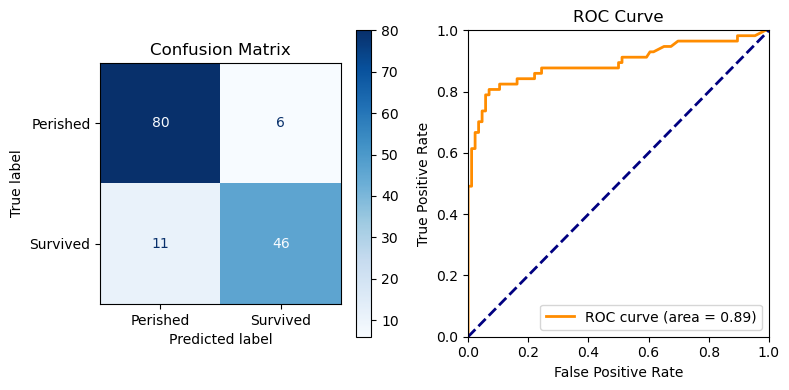

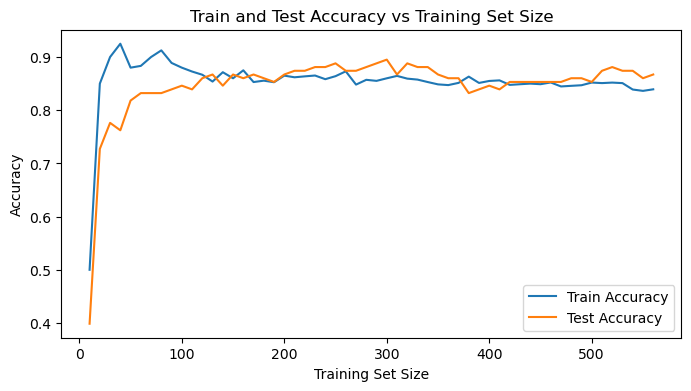

------------- MODEL METRICS --------------
Accuracy: 0.79
Precision: 0.69
Recall: 0.71
Specificity: 0.83


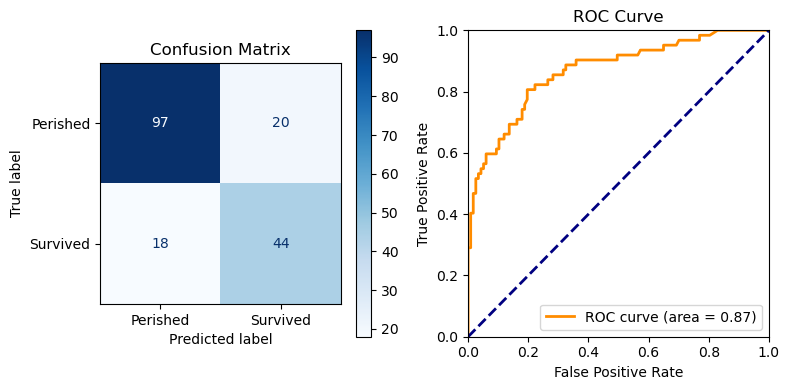

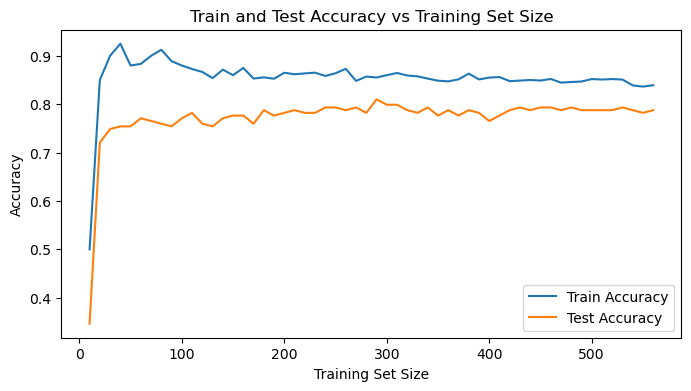

In [20]:
# Train the Random Forest model with the new features
RandomForest = RandomForestClassifier(
    random_state=18,
    **grid_search.best_params_
)

train_timer(RandomForest, X_train, Y_train)
Yhat, Yhat_prob, metrics = evaluate_model(
    RandomForest,
    X_dev,
    Y_dev
)
print_metrics(metrics)
plot_evaluation_graphs(Y_dev, Yhat, Yhat_prob)
train_eval = train_set_evaluation(
    RandomForest,
    X_train,
    Y_train,
    X_dev,
    Y_dev
)
plot_accuracy(train_eval)

# Evaluate the model on the test set
Yhat, Yhat_prob, metrics = evaluate_model(
    RandomForest,
    X_test,
    Y_test
)
print_metrics(metrics)
plot_evaluation_graphs(Y_test, Yhat, Yhat_prob)

# Plot accuracy graph for the test set
train_eval = train_set_evaluation(
    RandomForest,
    X_train,
    Y_train,
    X_test,
    Y_test
)
plot_accuracy(train_eval)

Best parameters:
{'classifier__max_depth': 8,
 'classifier__min_samples_leaf': 4,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 128}
Best cross-validation accuracy: 0.847
Test set accuracy with best model: 0.788
------------- MODEL METRICS --------------
Accuracy: 0.89
Precision: 0.90
Recall: 0.81
Specificity: 0.94


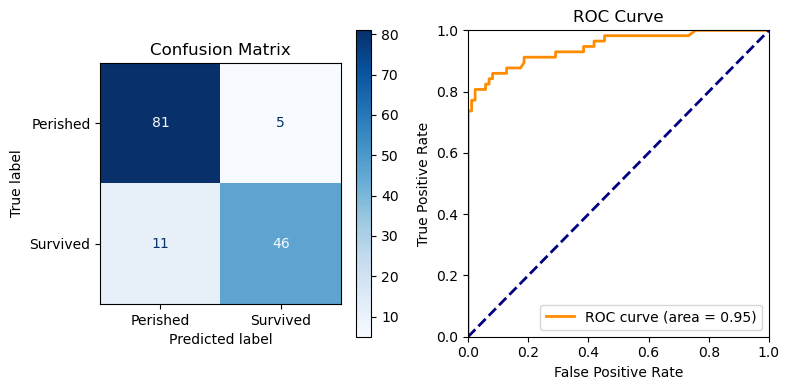

------------- MODEL METRICS --------------
Accuracy: 0.79
Precision: 0.70
Recall: 0.68
Specificity: 0.85


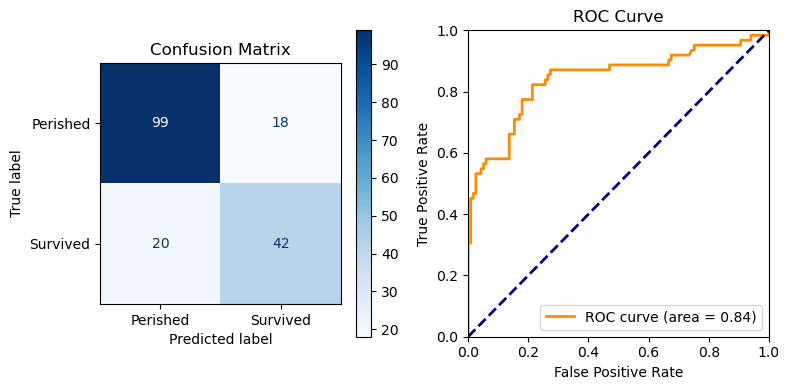

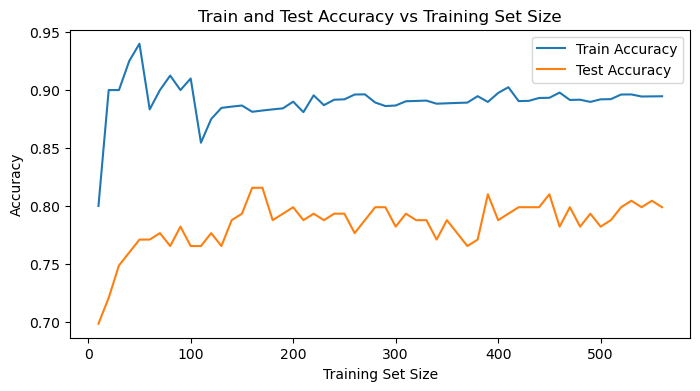

In [21]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

# Define a more extensive parameter grid for Random Forest
param_grid_extensive = {
    'classifier__n_estimators': [32, 64, 128, 256],
    'classifier__max_depth': [4, 8, 16, 32],
    'classifier__min_samples_split': [2, 4, 8, 16],
    'classifier__min_samples_leaf': [1, 2, 4, 8]
}

# Create a pipeline with RFE and Random Forest
pipeline = Pipeline([
    ('feature_selection', RFE(estimator=RandomForestClassifier(random_state=18), n_features_to_select=10)),
    ('classifier', RandomForestClassifier(random_state=18))
])

# Initialize Grid Search with cross-validation
grid_search_extensive = GridSearchCV(
    pipeline,
    param_grid_extensive,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the grid search
grid_search_extensive.fit(X_train_cv, Y_train_cv)

# Print best parameters and score
print('Best parameters:')
pprint(grid_search_extensive.best_params_)
print(f"Best cross-validation accuracy: {grid_search_extensive.best_score_:.3f}")

# Evaluate best model on test set
best_model_extensive = grid_search_extensive.best_estimator_
test_accuracy_extensive = accuracy_score(Y_test, best_model_extensive.predict(X_test))
print(f"Test set accuracy with best model: {test_accuracy_extensive:.3f}")

# Evaluate the model on the development set
Yhat, Yhat_prob, metrics = evaluate_model(
    best_model_extensive,
    X_dev,
    Y_dev
)
print_metrics(metrics)
plot_evaluation_graphs(Y_dev, Yhat, Yhat_prob)

# Evaluate the model on the test set
Yhat, Yhat_prob, metrics = evaluate_model(
    best_model_extensive,
    X_test,
    Y_test
)
print_metrics(metrics)
plot_evaluation_graphs(Y_test, Yhat, Yhat_prob)

# Plot accuracy graph for the test set
train_eval = train_set_evaluation(
    best_model_extensive,
    X_train,
    Y_train,
    X_test,
    Y_test
)
plot_accuracy(train_eval)

In [22]:
print(f"Best cross-validation accuracy: {grid_search_extensive.best_score_:.3f}")
print(f"Test set accuracy with best model: {test_accuracy_extensive:.3f}")

Best cross-validation accuracy: 0.847
Test set accuracy with best model: 0.788


Model training time: 139.19 ms
------------- MODEL METRICS --------------
Accuracy: 0.87
Precision: 0.87
Recall: 0.79
Specificity: 0.92


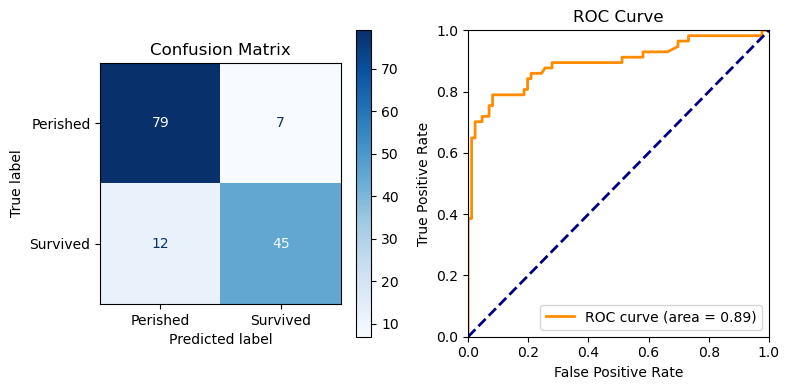

------------- MODEL METRICS --------------
Accuracy: 0.80
Precision: 0.71
Recall: 0.73
Specificity: 0.85


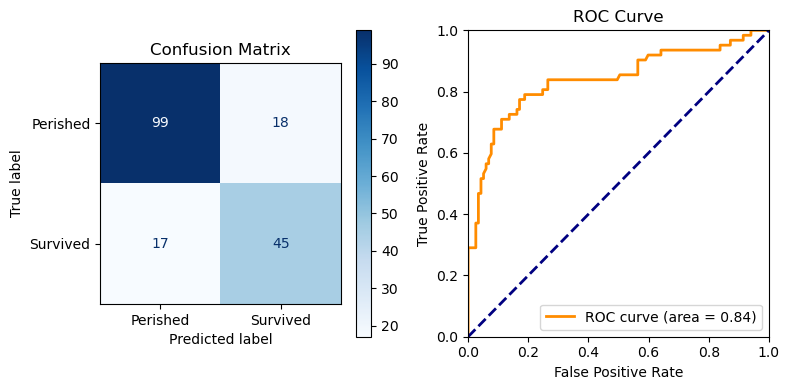

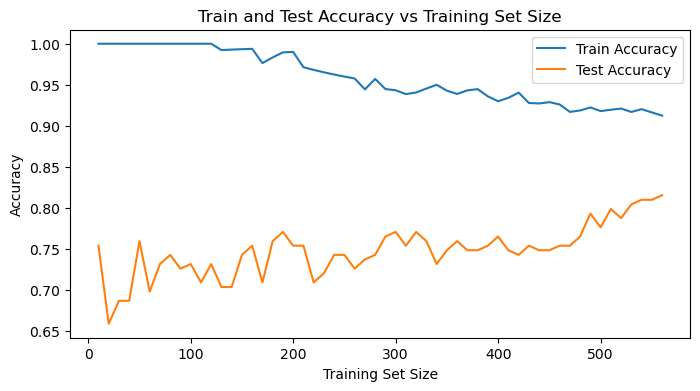

In [26]:
# Initialize the Gradient Boosting Classifier
GradientBoosting = GradientBoostingClassifier(random_state=18)

# Train the model
train_timer(GradientBoosting, X_train, Y_train)

# Evaluate the model on the development set
Yhat, Yhat_prob, metrics = evaluate_model(
    GradientBoosting,
    X_dev,
    Y_dev
)
print_metrics(metrics)
plot_evaluation_graphs(Y_dev, Yhat, Yhat_prob)

# Evaluate the model on the test set
Yhat, Yhat_prob, metrics = evaluate_model(
    GradientBoosting,
    X_test,
    Y_test
)
print_metrics(metrics)
plot_evaluation_graphs(Y_test, Yhat, Yhat_prob)

# Plot accuracy graph for the test set
train_eval = train_set_evaluation(
    GradientBoosting,
    X_train,
    Y_train,
    X_test,
    Y_test
)
plot_accuracy(train_eval)

